# Data Mining for Retail Stores

### Author: Konstantinos Nikopoulos 



Goal: Find an interesting group/cluster for Marketing department in groceries dataset.

## Preprocess dataset

In [2]:
# Read csv file:
groceries <- read.csv("DATA/GroceriesInitial.csv", header=TRUE,sep = ",")

# Transform variables to binary form:
product_names <- levels(unlist(groceries[,4:35]))
temp_blank <- which(product_names == "") 
product_names <- product_names[-c(temp_blank)]
products <- as.data.frame(t(apply(groceries[,4:35],1, function(x)
(product_names) %in% as.character(unlist(x)))))
names(products) <- product_names
groceries_binary <- cbind(groceries[,1:3],products)
                
# Keep only 13 specific products:
groceries_binary_ready <- groceries_binary[,c("citrus fruit", "tropical fruit", "whole milk", 
"other vegetables", "rolls/buns", "chocolate", "bottled water", "yogurt",
"sausage", "root vegetables", "pastry", "soda", "cream", "basket_value", "recency_days")]

# Transform basket_value to discrete (3 values):
groceries_discrete <- groceries_binary_ready
cut_points <- quantile(groceries_discrete$basket_value ,probs = c(0,0.33, 0.66,1) ,na.rm = TRUE ,names = FALSE)
groceries_discrete$basket_value_bin <- cut(groceries_discrete$basket_value
,breaks = cut_points,labels=c("low_value_basket", "medium_value_basket", "high_value_basket"),include.lowest = TRUE)

# Transform the discrete values of basket_value to binary form:
                                  
# Function for transform a variable in binary form:
binarize <-function(data_columns,extra_columns=NULL){
    column_names <- levels(unlist(data_columns))
    blank <- which(column_names == "")
    if (length(blank) !=0)
    column_names <- column_names[-c(blank)]
    binary_result <- as.data.frame(t(apply(data_columns,1
    ,function(x) column_names %in% as.character(unlist(x)))))
    names(binary_result) <- column_names
    if (is.null(extra_columns)==FALSE)
    binary_result<- cbind(extra_columns,binary_result)
    return(binary_result)
}

# Apply the above function on discrete values of basket_value:
groceries_discrete <- binarize(as.data.frame(groceries_discrete$basket_value_bin),groceries_discrete)
groceries_discrete <- groceries_discrete[,-c(which(colnames(groceries_discrete)=="basket_value_bin"))]
print(groceries_discrete[1:5,])



  citrus fruit tropical fruit whole milk other vegetables rolls/buns chocolate
1         TRUE          FALSE      FALSE            FALSE      FALSE     FALSE
2        FALSE           TRUE      FALSE            FALSE      FALSE     FALSE
3        FALSE          FALSE       TRUE            FALSE      FALSE     FALSE
4        FALSE          FALSE      FALSE            FALSE      FALSE     FALSE
5        FALSE          FALSE       TRUE             TRUE      FALSE     FALSE
  bottled water yogurt sausage root vegetables pastry  soda cream basket_value
1         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE          1.1
2         FALSE   TRUE   FALSE           FALSE  FALSE FALSE FALSE          3.6
3         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE          1.2
4         FALSE   TRUE   FALSE           FALSE  FALSE FALSE FALSE          6.6
5         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE          2.5
  recency_days low_value_basket medium_value_basket 

## Association rules with Apriori Algorithm

##### Apply Apriori Algorithm with different values of min support

Dataset: only products

In [4]:
library(arules)

# Make a dataframe without basket_value, recency_days,low_value_basket, medium_value_basket, high_value_basket:
groceries_discrete_products_only <- groceries_discrete[,-(14:18),drop=FALSE] 

# Create rules with apriori algorithm:
# min sup = 0.25:
rules_0_25 <- apriori(groceries_discrete_products_only,parameter = list(minlen=2, supp=0.25, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.1:
rules_0_1 <- apriori(groceries_discrete_products_only,parameter = list(minlen=2, supp=0.1, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.01:
rules_0_01 <- apriori(groceries_discrete_products_only,parameter = list(minlen=2, supp=0.01, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.001:
rules_0_001 <- apriori(groceries_discrete_products_only,parameter = list(minlen=2, supp=0.001, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.0001:
rules_0_0001 <- apriori(groceries_discrete_products_only,parameter = list(minlen=2, supp=0.0001, conf=0.8)
,control = list(verbose=FALSE))

print(rules_0_25) 
print(rules_0_1) 
print(rules_0_01) 
print(rules_0_001) 
print(rules_0_0001) 


set of 0 rules 
set of 0 rules 
set of 0 rules 
set of 23 rules 
set of 3258 rules 


#### Find 20 rules with highest confidence

Dataset: only products (same)

In [25]:
# I want to keep 20 rules with best confidence:
#rules_0_25  -> 0 rules -> too few
#rules_0_1  -> 0 rules -> too few
#rules_0_01  -> 0 rules -> too few
#rules_0_001  -> 23 rules -> ok
#rules_0_0001  -> 3258 rules -> too many

# For min sup = 0.001, i will keep the best 20:
rules_1<-head(rules_0_001, n=20, by="confidence")
inspect(rules_1)

     lhs                   rhs                    support confidence     lift count
[1]  {tropical fruit,                                                              
      rolls/buns,                                                                  
      sausage,                                                                     
      root vegetables}  => {whole milk}       0.001326964  1.0000000 2.998806    10
[2]  {tropical fruit,                                                              
      rolls/buns,                                                                  
      bottled water,                                                               
      yogurt,                                                                      
      root vegetables}  => {whole milk}       0.001061571  1.0000000 2.998806     8
[3]  {tropical fruit,                                                              
      yogurt,                                                               

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


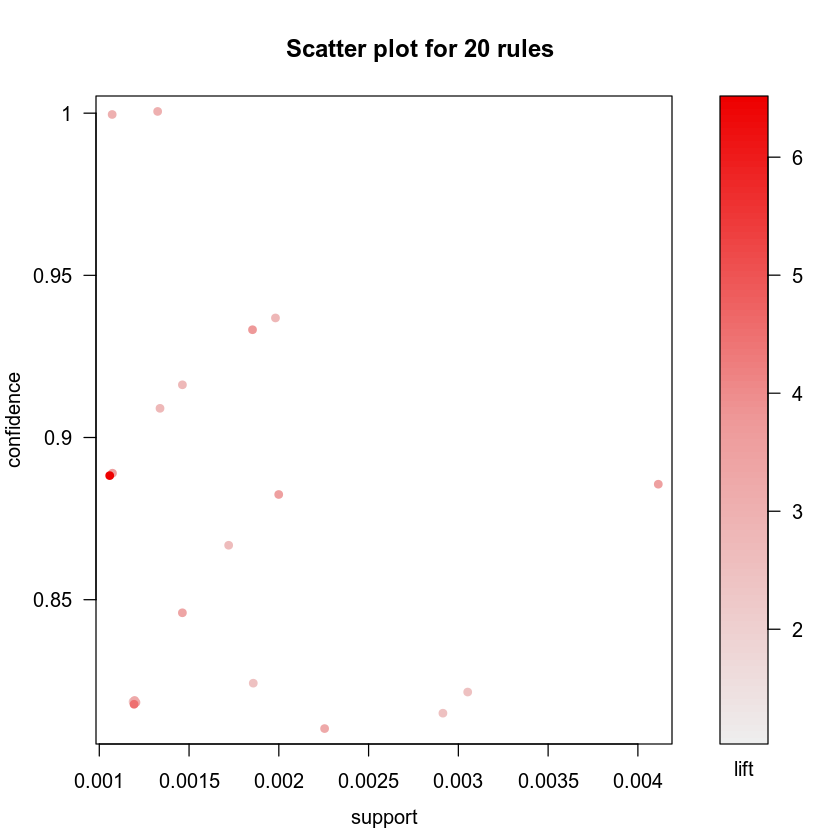

In [26]:
library(arulesViz)

# Plot rules:
plot(rules_1)

 The strangest rule for me is {chocolate, root vegetables, pastry} => {other vegetables}, because chocolate and vegetables are frequently purchased together.

#### Find 20 rules with highest confidence

Dataset: products with discrete values of basket_value

In [27]:
# Make a dataframe without basket_value and recency_days:
groceries_discrete_products <- groceries_discrete[,-(14:15),drop=FALSE] 

# Create rules with apriori algorithm:
# min sup = 0.25:
rules_0_25 <- apriori(groceries_discrete_products,parameter = list(minlen=2, supp=0.25, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.1:
rules_0_1 <- apriori(groceries_discrete_products,parameter = list(minlen=2, supp=0.1, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.01:
rules_0_01 <- apriori(groceries_discrete_products,parameter = list(minlen=2, supp=0.01, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.001:
rules_0_001 <- apriori(groceries_discrete_products,parameter = list(minlen=2, supp=0.001, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.0001:
rules_0_0001 <- apriori(groceries_discrete_products,parameter = list(minlen=2, supp=0.0001, conf=0.8)
,control = list(verbose=FALSE))

# I want to keep 20 rules with best conf:
#print(rules_0_25) # -> 0 rules -> too few
#print(rules_0_1) # -> 1 rules -> too few
#print(rules_0_01) # -> 63 rules -> ok
#print(rules_0_001) # -> 750 rules -> too many
#print(rules_0_0001) # -> 9229 rules -> too many

# For min sup = 0.01, i will keep the best 20:
rules_2<-head(rules_0_01, n=20, by="confidence")
inspect(rules_2)



     lhs                   rhs                    support confidence     lift count
[1]  {chocolate,                                                                   
      pastry}           => {high_value_basket} 0.01048301          1 3.008383    79
[2]  {citrus fruit,                                                                
      sausage}          => {high_value_basket} 0.01472930          1 3.008383   111
[3]  {sausage,                                                                     
      pastry}           => {high_value_basket} 0.01632166          1 3.008383   123
[4]  {tropical fruit,                                                              
      pastry}           => {high_value_basket} 0.01725053          1 3.008383   130
[5]  {rolls/buns,                                                                  
      pastry}           => {high_value_basket} 0.02733546          1 3.008383   206
[6]  {bottled water,                                                        

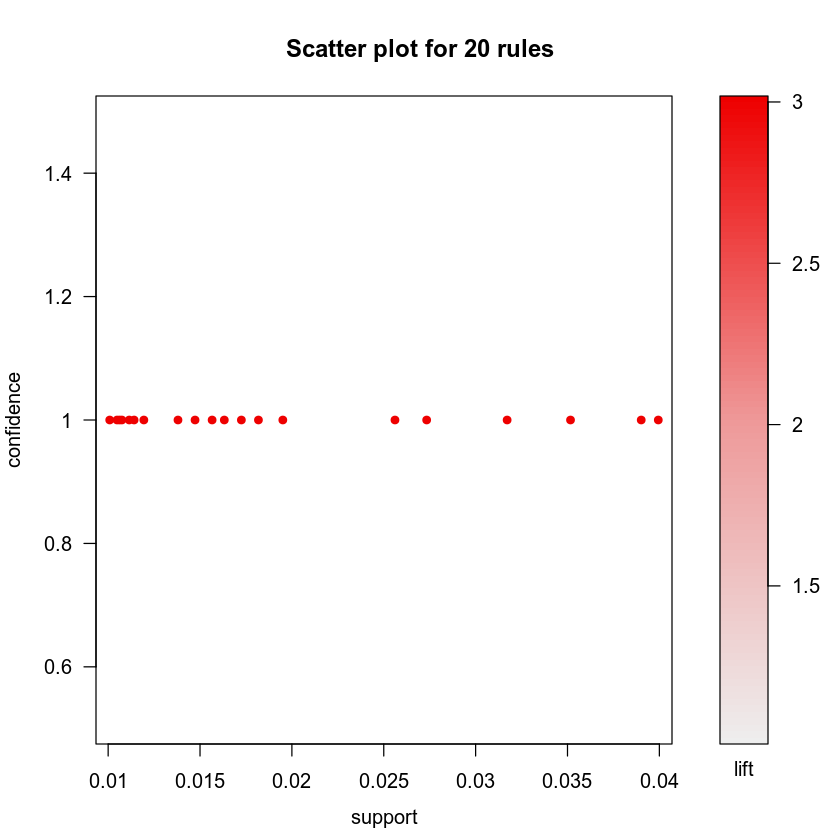

In [28]:
# Plot rules:
plot(rules_2)

It seems that the most expensive product is sausage, because is the product who appears in most rules with high value.

## Clustering with k-means Algorithm

#### K-means on basket_value and recency_days (5 clusters)

In [29]:
# Keep only basket_value and recency_days:
data <- groceries[,-(4:35),drop=FALSE] # delete products
data <- data[,-(1:1),drop=FALSE] # delete id

# Apply k-means:
set.seed(1234)
kmeans_fit <- kmeans(data, 5, nstart = 25,iter.max = 1000)
str(kmeans_fit)


List of 9
 $ cluster     : int [1:7536] 5 3 5 5 4 2 4 2 5 1 ...
 $ centers     : num [1:5, 1:2] 7.88 2.91 3.88 5.42 4.87 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5] "1" "2" "3" "4" ...
  .. ..$ : chr [1:2] "basket_value" "recency_days"
 $ totss       : num 4854841
 $ withinss    : num [1:5] 40159 25790 28338 59959 57874
 $ tot.withinss: num 212119
 $ betweenss   : num 4642722
 $ size        : int [1:5] 1215 1151 1217 1914 2039
 $ iter        : int 2
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


K-means returns a good clustering as output for this dataset (and with k=5)

#### Cluster analysis

In [30]:
# Centers of clusters:
kmeans_fit$centers

# Mean of centers of clusters:
mean <- mean(kmeans_fit$centers)
cat("mean:",mean,"\n")

# Stantard deviation of centers of clusters:
std <- sd(kmeans_fit$centers)
cat("std:",std)


basket_value,recency_days
7.875556,22.139918
2.912685,54.591659
3.880279,37.978636
5.421630,70.541797
4.872536,6.864149


mean: 21.70788 
std: 24.40956

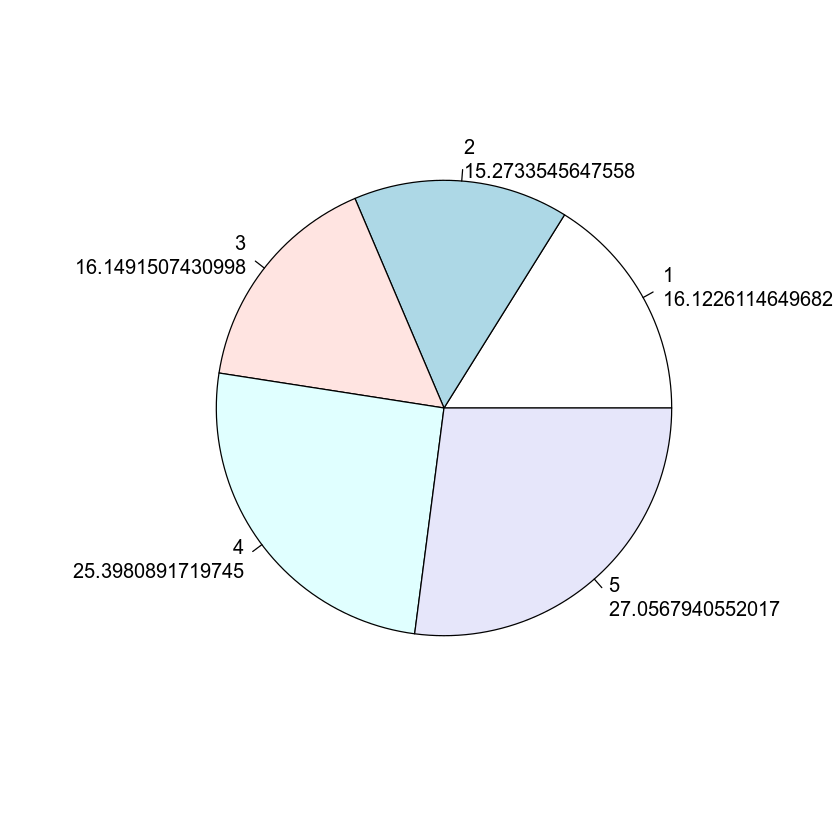

In [31]:
# Pie table for clusters:
pie_data <- table(kmeans_fit$cluster)
pie_data <- pie_data/sum(pie_data)*100
pie(pie_data,labels = paste(names(pie_data), "\n", pie_data, sep=""))


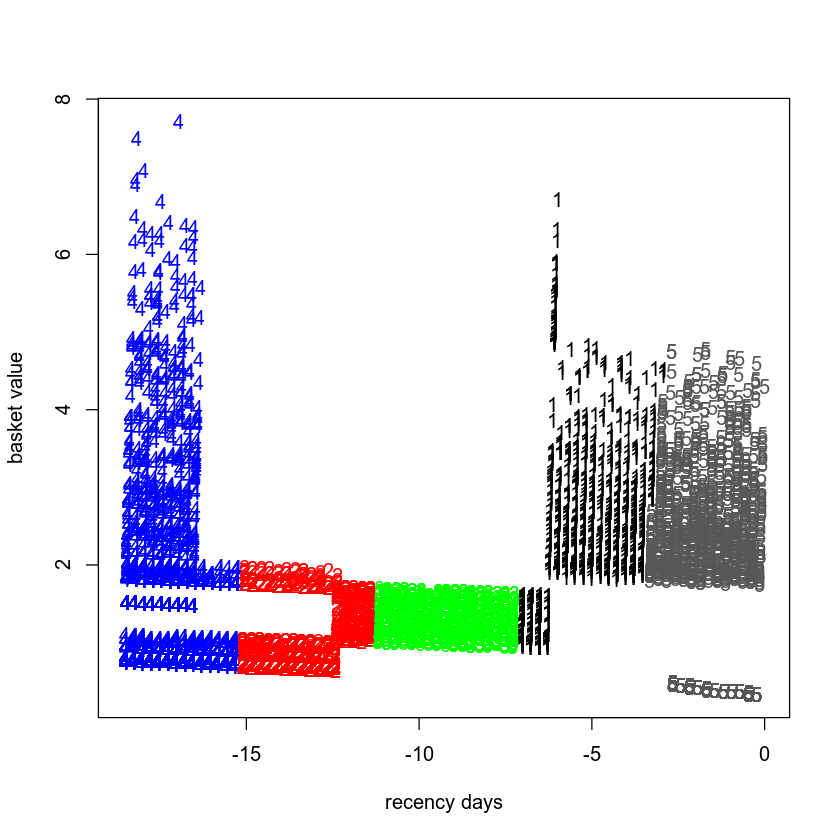

In [34]:
library(fpc)

# Plot clusters:
plotcluster(data, kmeans_fit$cluster,xlab = "recency days" ,ylab = "basket value")

Cluster 1:
Average basket value.(16% of all transactions)

Cluster 2: 
Low basket value. (15% of all transactions)

Cluster 3:
Low basket value. (16% of all transactions)

Cluster 4:
Many days passed from these transactions. (25% of all transactions)

Cluster 5:
Average basket value. (27% of all transactions)


A worrying cluster is cluster 4 who has many transactions and high value in recency days. Marketing department should check this. 

#### Put clustering output in data

In [35]:
# Put clustering output as column to products data:
data_clustering <- cbind(groceries_discrete_products_only, clusterNum = kmeans_fit$cluster)

# Rename values of new column
data_clustering$clusterNum[data_clustering$clusterNum == 1] <- "Cluster1"
data_clustering$clusterNum[data_clustering$clusterNum == 2] <- "Cluster2"
data_clustering$clusterNum[data_clustering$clusterNum == 3] <- "Cluster3"
data_clustering$clusterNum[data_clustering$clusterNum == 4] <- "Cluster4"
data_clustering$clusterNum[data_clustering$clusterNum == 5] <- "Cluster5"

# Transform new column to binary form:
data_clustering <- binarize(as.data.frame(data_clustering$clusterNum),data_clustering)
data_clustering <- data_clustering[,-c(which(colnames(data_clustering)=="clusterNum"))]
print(data_clustering[1:5,])


  citrus fruit tropical fruit whole milk other vegetables rolls/buns chocolate
1         TRUE          FALSE      FALSE            FALSE      FALSE     FALSE
2        FALSE           TRUE      FALSE            FALSE      FALSE     FALSE
3        FALSE          FALSE       TRUE            FALSE      FALSE     FALSE
4        FALSE          FALSE      FALSE            FALSE      FALSE     FALSE
5        FALSE          FALSE       TRUE             TRUE      FALSE     FALSE
  bottled water yogurt sausage root vegetables pastry  soda cream Cluster1
1         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE    FALSE
2         FALSE   TRUE   FALSE           FALSE  FALSE FALSE FALSE    FALSE
3         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE    FALSE
4         FALSE   TRUE   FALSE           FALSE  FALSE FALSE FALSE    FALSE
5         FALSE  FALSE   FALSE           FALSE  FALSE FALSE FALSE    FALSE
  Cluster2 Cluster3 Cluster4 Cluster5
1    FALSE    FALSE    FALSE     TRUE


## Association rules using clustering output

In [36]:
# Create rules with apriori algorithm:
# min sup = 0.25:
rules_0_25 <- apriori(data_clustering,parameter = list(minlen=2, supp=0.25, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.1:
rules_0_1 <- apriori(data_clustering,parameter = list(minlen=2, supp=0.1, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.01:
rules_0_01 <- apriori(data_clustering,parameter = list(minlen=2, supp=0.01, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.001:
rules_0_001 <- apriori(data_clustering,parameter = list(minlen=2, supp=0.001, conf=0.8)
,control = list(verbose=FALSE))
# min sup = 0.0001:
rules_0_0001 <- apriori(data_clustering,parameter = list(minlen=2, supp=0.0001, conf=0.8)
,control = list(verbose=FALSE))

# I want to keep 20 rules with best conf:
#print(rules_0_25) # -> 0 rules -> too few
#print(rules_0_1) # -> 1 rules -> too few
#print(rules_0_01) # -> 20 rules -> few
#print(rules_0_001) # -> 385 rules -> ok
#print(rules_0_0001) # -> 10738 rules -> too many

# For min sup = 0.001, i will keep the best 20:
rules_3<-head(rules_0_001, n=20, by="confidence")
inspect(rules_3)

     lhs                                     rhs        support     confidence
[1]  {pastry}                             => {Cluster4} 0.116109342 1         
[2]  {chocolate,pastry}                   => {Cluster4} 0.010483015 1         
[3]  {citrus fruit,pastry}                => {Cluster4} 0.012738854 1         
[4]  {sausage,pastry}                     => {Cluster4} 0.016321656 1         
[5]  {sausage,Cluster4}                   => {pastry}   0.016321656 1         
[6]  {bottled water,pastry}               => {Cluster4} 0.011677282 1         
[7]  {tropical fruit,pastry}              => {Cluster4} 0.017250531 1         
[8]  {root vegetables,pastry}             => {Cluster4} 0.014331210 1         
[9]  {yogurt,pastry}                      => {Cluster4} 0.023089172 1         
[10] {pastry,soda}                        => {Cluster4} 0.027468153 1         
[11] {rolls/buns,pastry}                  => {Cluster4} 0.027335456 1         
[12] {other vegetables,pastry}            => {Cluste

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


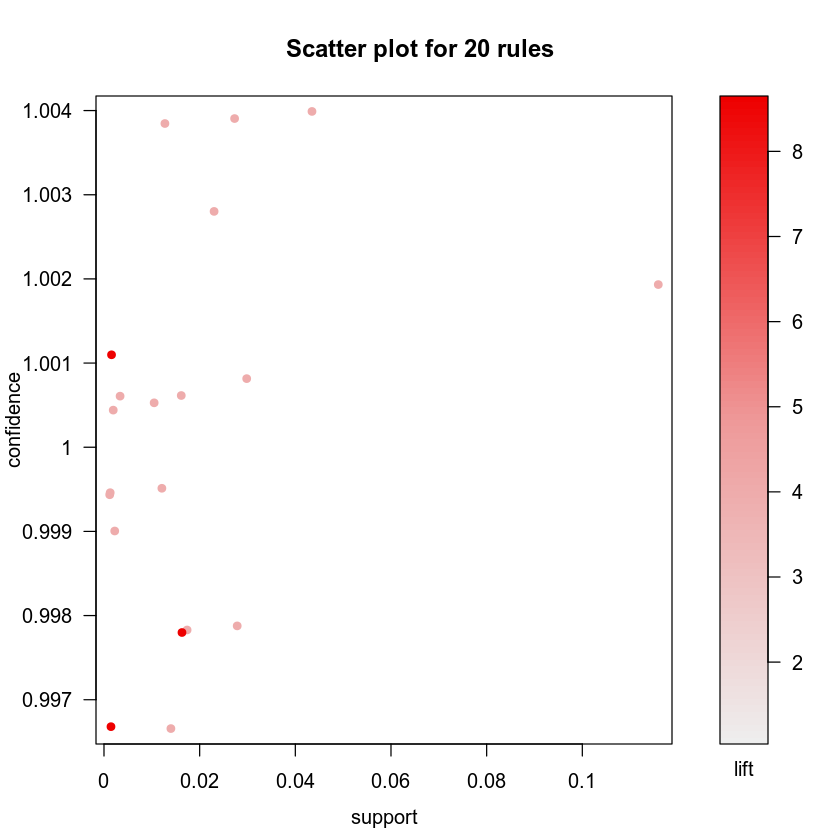

In [37]:
# Plot rules:
plot(rules_3)

From 5 clusters, only cluster 4 appears in association rules.

In cluster 4, most frequently purchased products are: pastry,chocolate,sausage

It seems that the worrying cluster is the only one who appears in these rules. The main product who affects this cluster is pastry. 